# Standard BESCA workflow

The current workflow works with the Scanpy version 2.8.

Changes: 
- Adding leiden clustering as default and a generic cluster function.
- BBKNN is the default batch correction method

### Import section ###

In [1]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns
from sinfo import sinfo

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

/home/david/.local/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/david/.local/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [2]:
# decisions to be made
use_example_dataset = True # If True, the pipeline will run using the example dataset shipped with BESCA

species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'standard_workflow_besca2.0'
split_condition='donor' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'MyAnno' # define name under which the labeling should be exported
labeling_description = 'celltype annotation' #define description which should be saved to labeling_info file
labeling_author = 'author' #define author which should be saved to labeling info file

### Define Input ###

In [3]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()

### Standard parameters - these should be kept as stable as possible ###

In [4]:
# the standard parameter section
standard_min_genes = 500
standard_min_cells = 30
standard_min_counts = 1000
standard_n_genes = 4500 # this is the most tricky one to set
standard_percent_mito = 0.1
standard_max_counts = 100000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [5]:
# define standardized file paths based on the input above
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

# read input data
if use_example_dataset:
    ## Currently this fails, solving issue 19 will help
    adata = bc.datasets.pbmc_storage_raw()
else:
    adata = bc.st.read_matrix(root_path)


LOG MESSAGE: Standard Pipeline Version 2.8 used
LOG MESSAGE: 2020-05-19
LOG MESSAGE: Analysis 'standard_workflow_besca2.0' on data located in'/mnt/projects/besca/workbooks'
LOG MESSAGE: species: human
LOG MESSAGE: Batch effect to correct: None
LOG MESSAGE: Parameters:
LOG MESSAGE: 	standard_min_genes = 500
LOG MESSAGE: 	standard_min_cells = 30
LOG MESSAGE: 	standard_min_counts = 1000
LOG MESSAGE: 	standard_n_genes = 4500
LOG MESSAGE: 	standard_max_counts = 100000
LOG MESSAGE: 	standard_percent_mito = 0.1
LOG MESSAGE: 	Time for creating all output directories and setting up logging: 0.063s


all output directories created successfully


In [6]:
adata

AnnData object with n_obs × n_vars = 13066 × 19883 
    obs: 'CELL', 'CONDITION', 'experiment', 'sample_type', 'storage_condition', 'donor', 'batch'
    var: 'ENSEMBL', 'SYMBOL'

In [7]:
# calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata, species=species)

### Visualization of quality control plots and selected filtering parameters

#### Count occurrence

This plot shows cell counts per sample

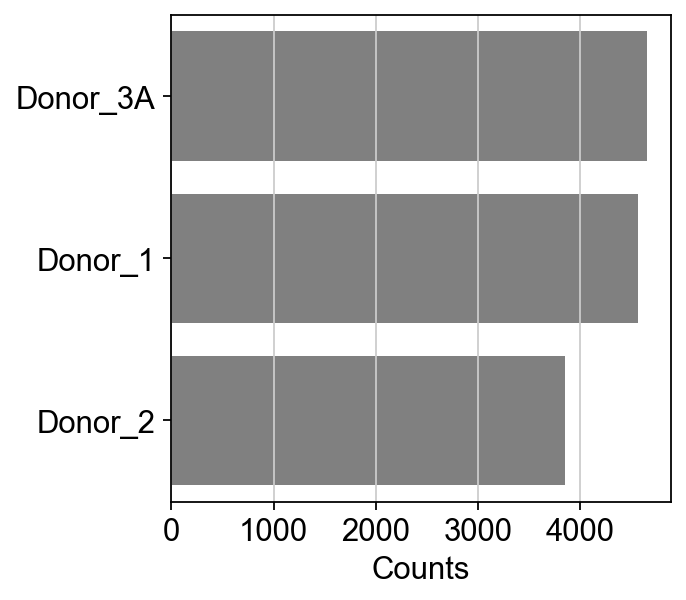

In [8]:
temp=bc.tl.count_occurrence(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

#### Transcript capture efficiency

This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

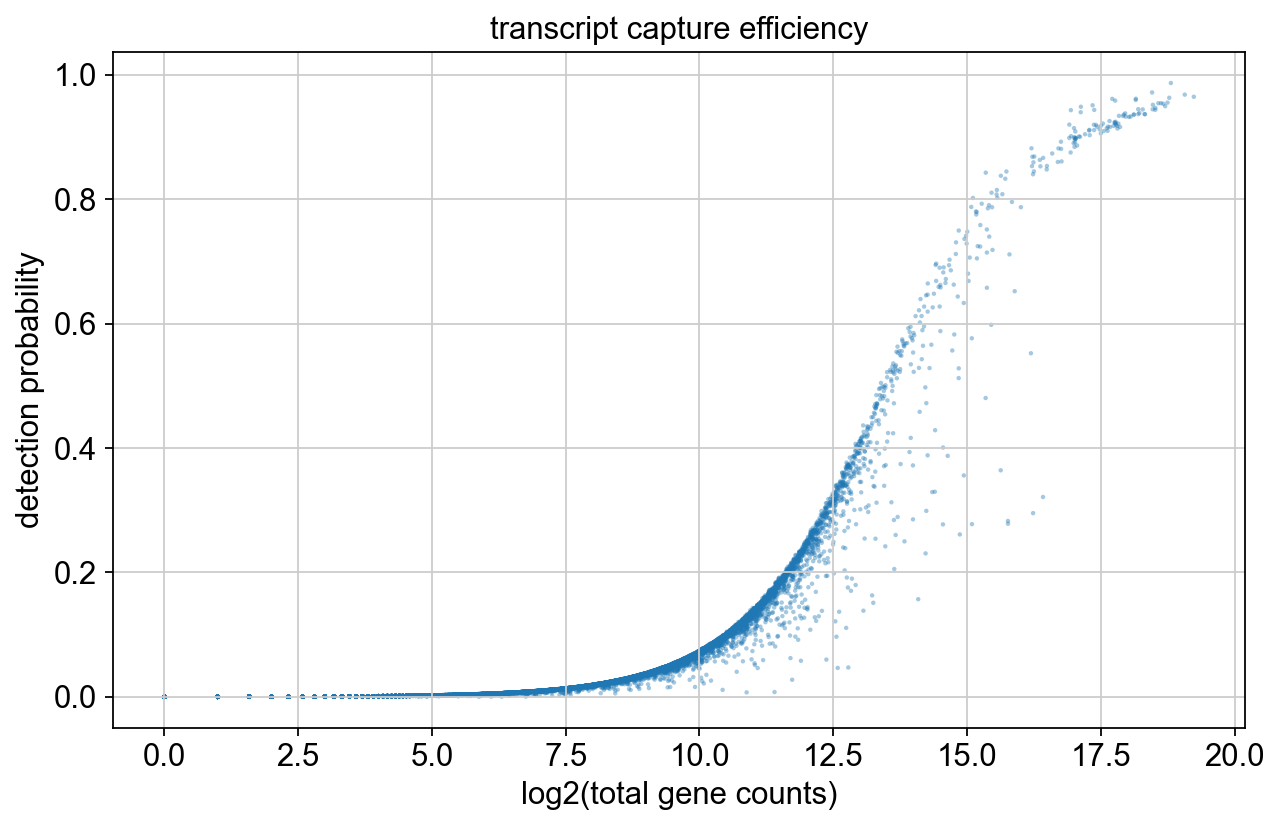

In [9]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

#### Library size distribution

This plot gives you an idea about the library size distribution in your dataset before processing.

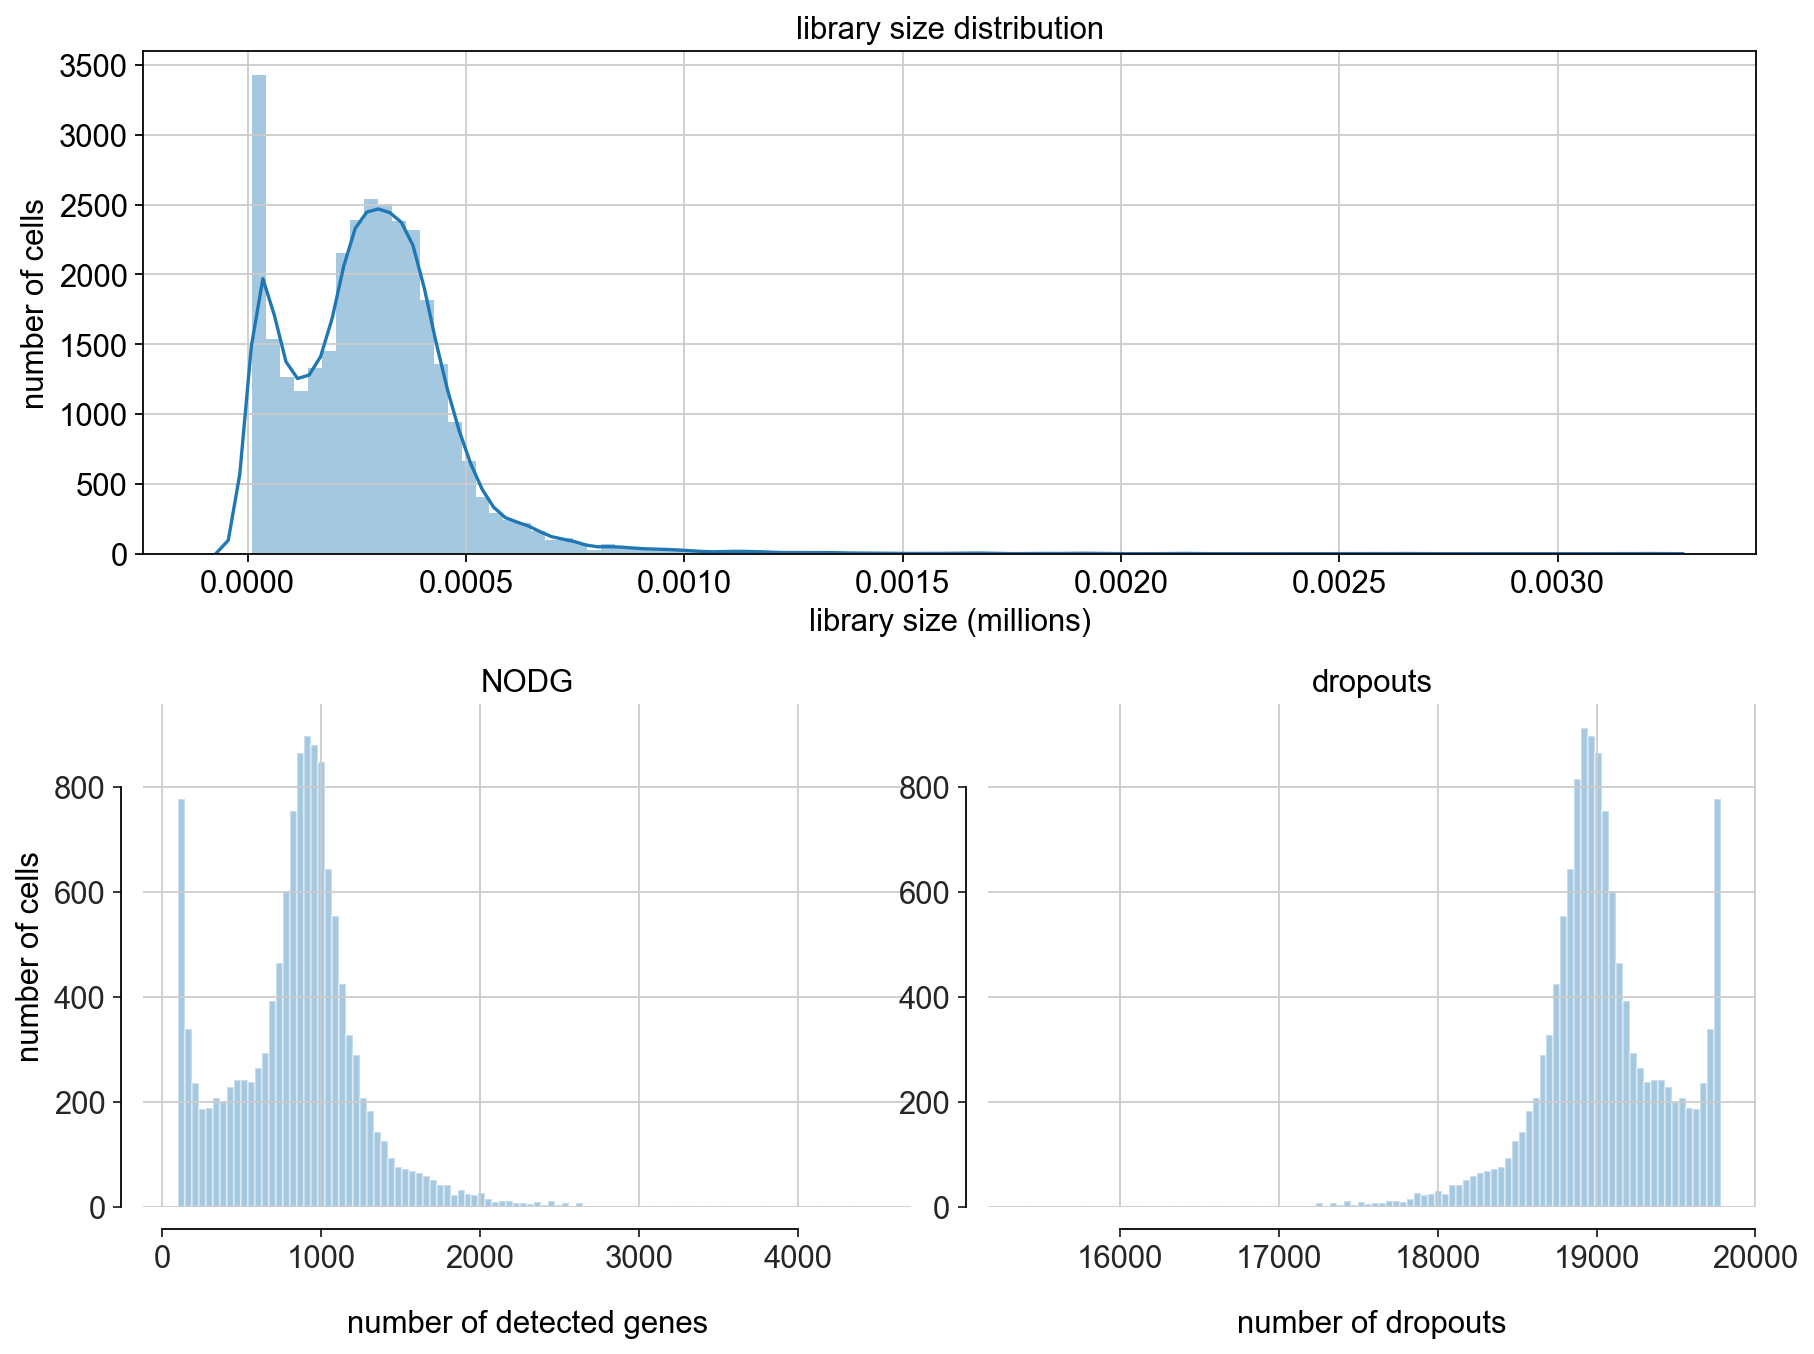

In [10]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [11]:
adata_unfiltered = adata.copy()

#### The effect of filtering parameters

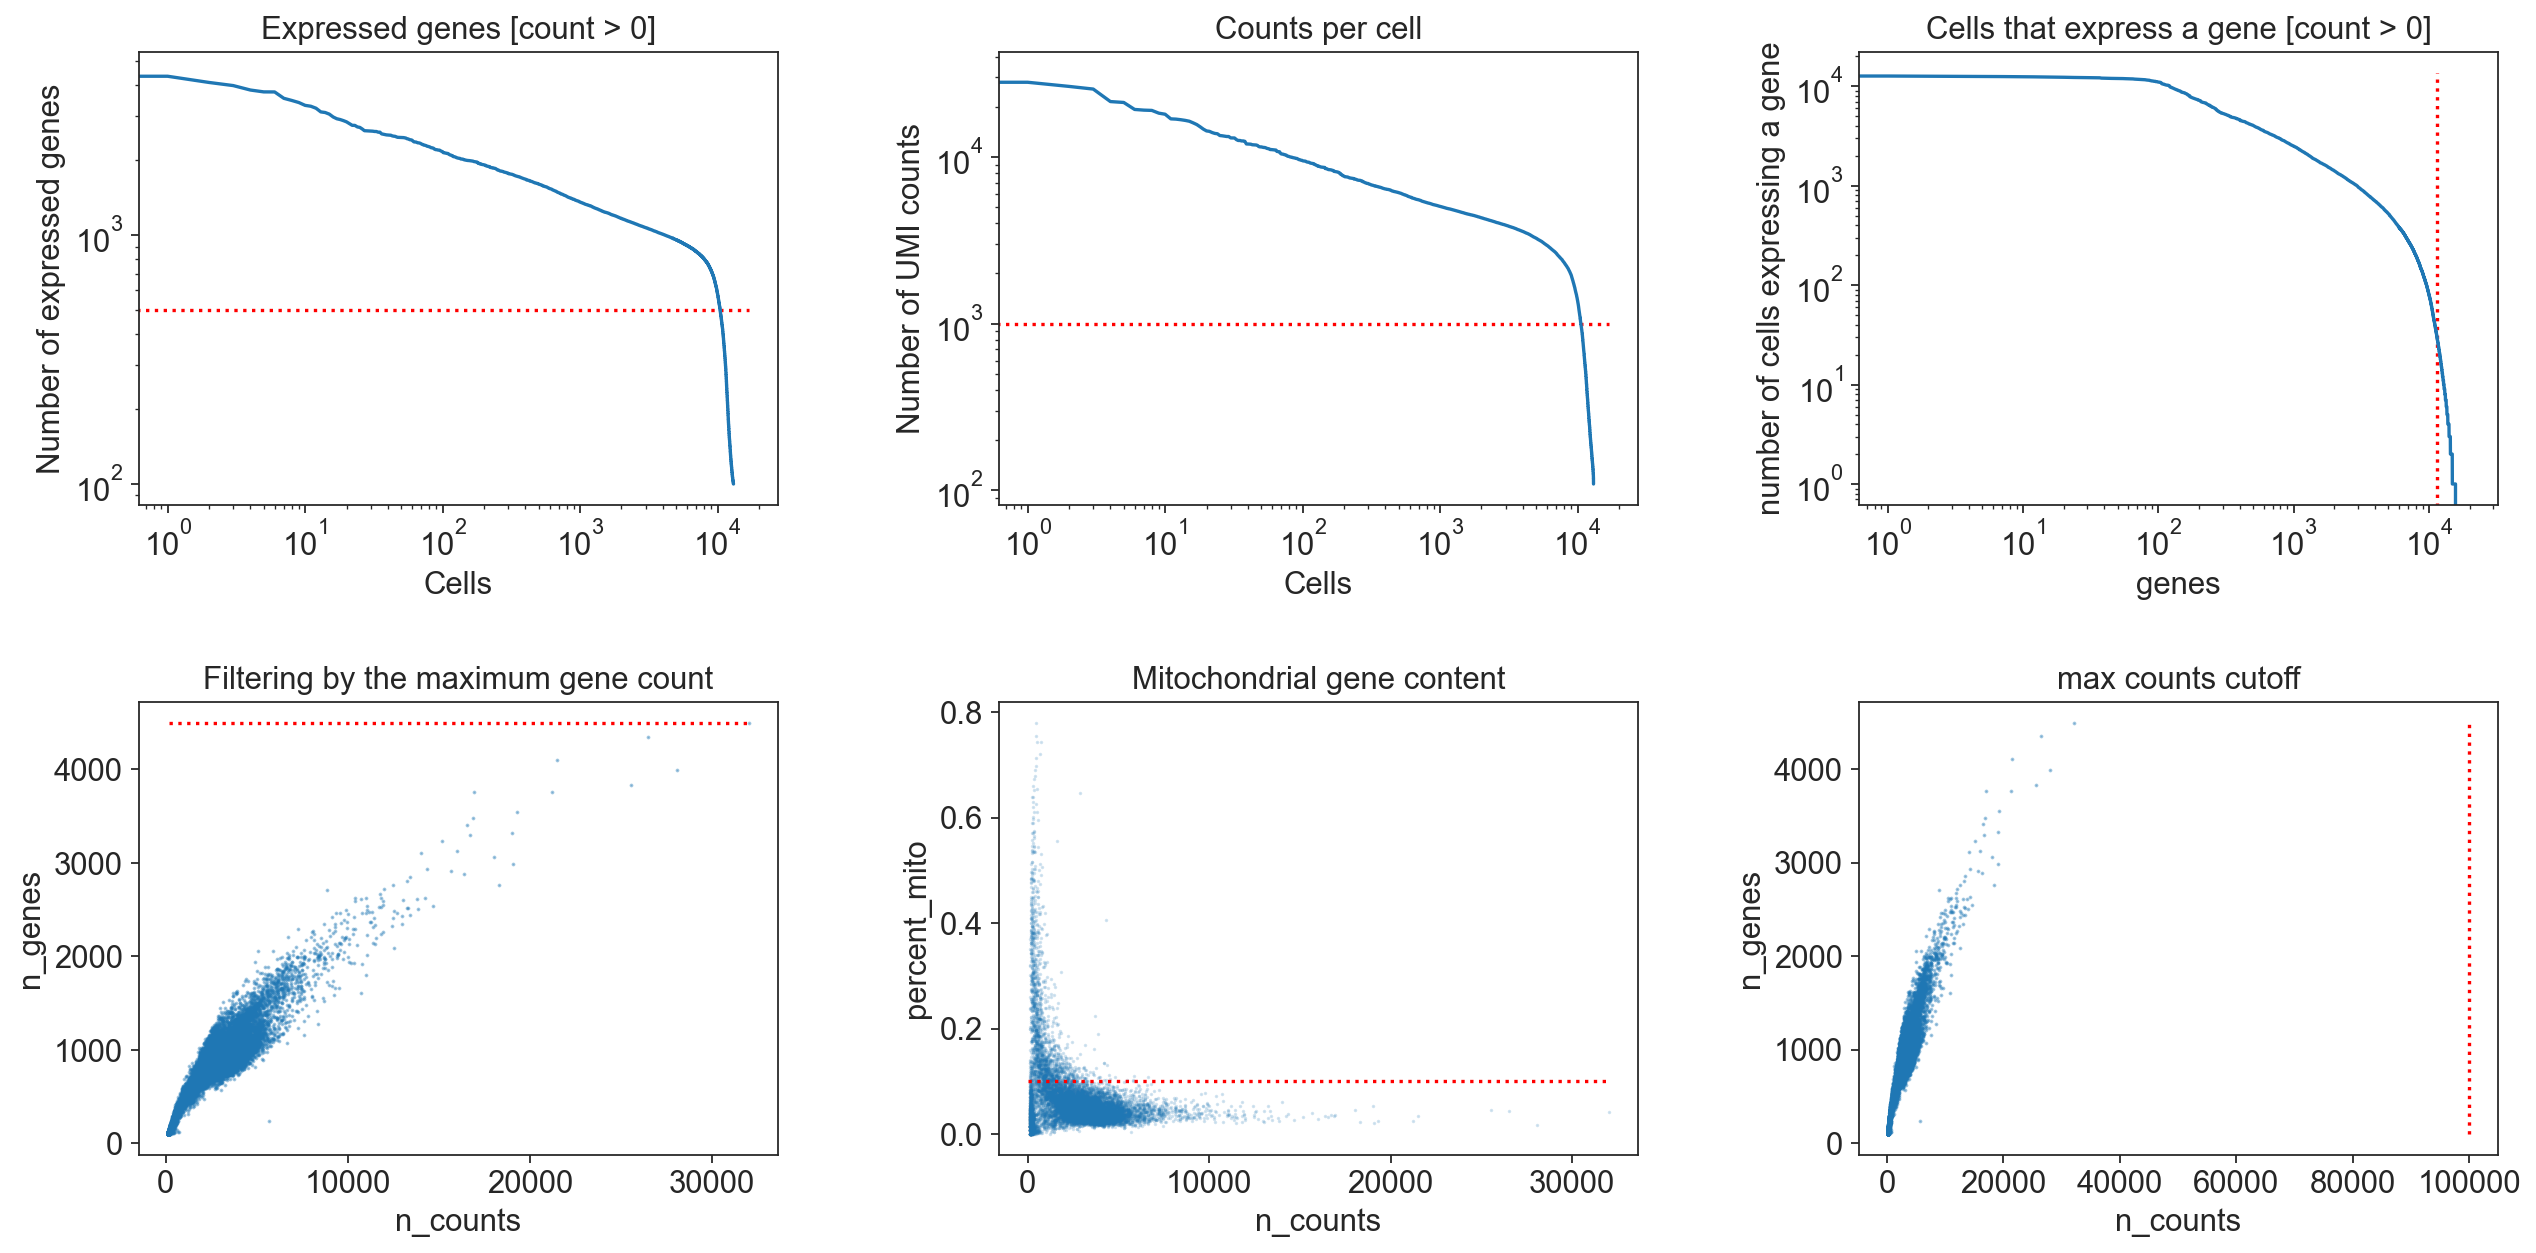

In [12]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

#### Scanpy plots of genes, counts, and mitochondria gene counts

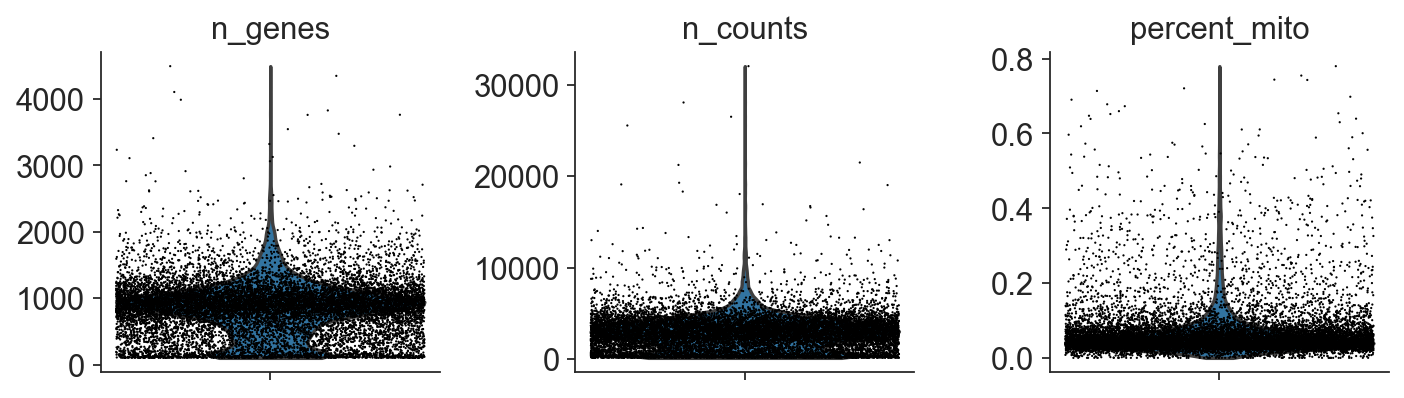

In [13]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.before_filtering.png')

#### Mitochondrial genes, genes, and counts by samples grouped by the split condition

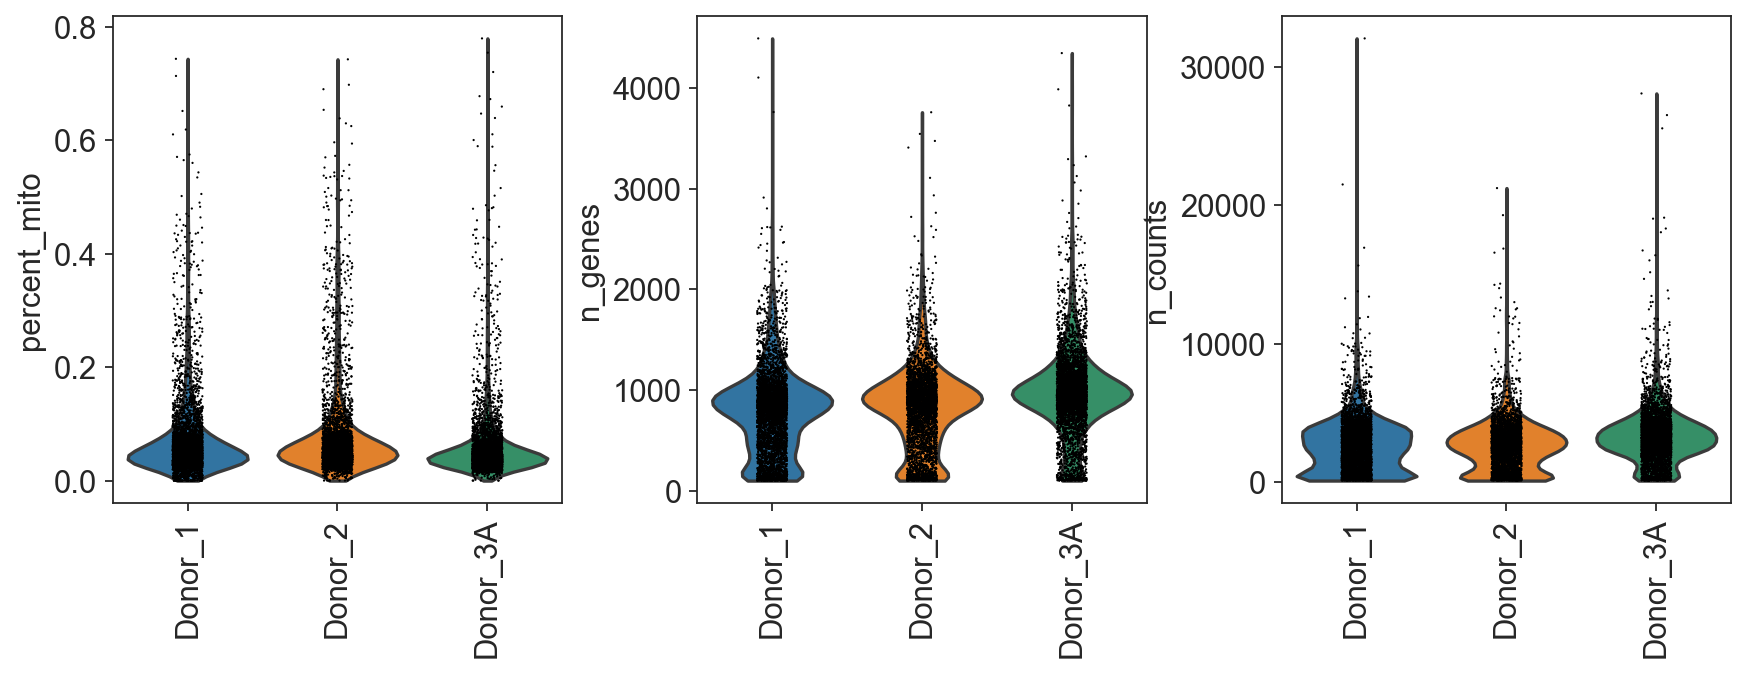

In [14]:
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### Filtering

#### Filtering with thresholds of gene and cell counts

In [15]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 10362 cells, 11500 genes
LOG MESSAGE: 	Time for filtering: 0.441s


In [16]:
filtering1.show()

started with  13066  total cells and  19883  total genes
removed 2624 cells that did not express at least 500  genes
removed 80 cells that did not have at least 1000 counts
removed 8383 genes that were not expressed in at least 30 cells
finished with 10362  total cells and 11500 total genes


#### Filtering with thresholds of proportion of mitochondrial genes and the upper limit of gene counts

In [17]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 9842 cells, 11500 genes
LOG MESSAGE: 	Time for filtering: 0.326s


In [18]:
filtering2.show()

started with  10362  total cells and  11500  total genes
removed 0 cells that expressed more than 4500 genes
removed 0 cells that had more than 100000  counts
removed  520  cells that expressed  10.0 percent mitochondrial genes or more
finished with 9842  total cells and 11500 total genes


#### Visualising QC metrics of the filtered dataset

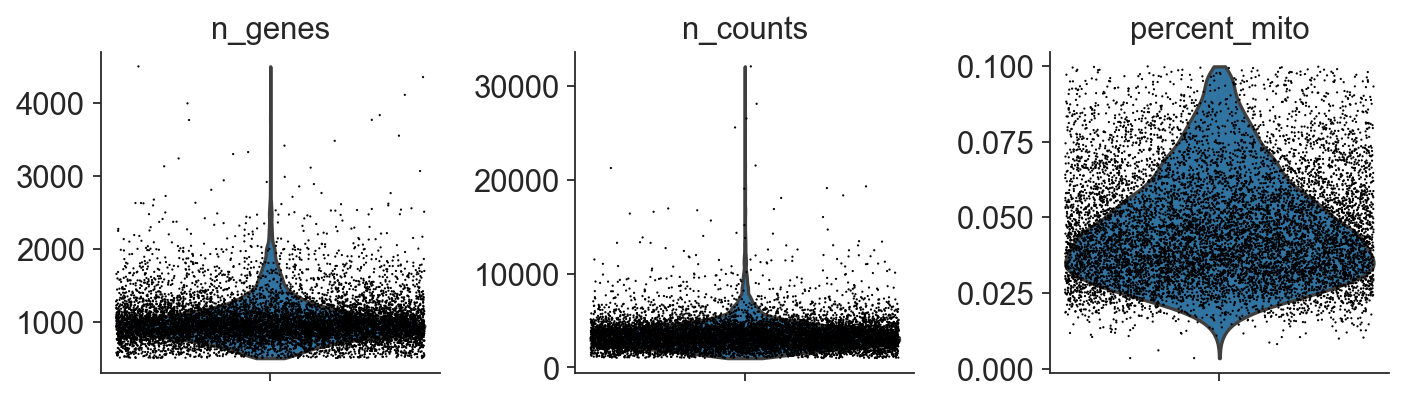

In [19]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

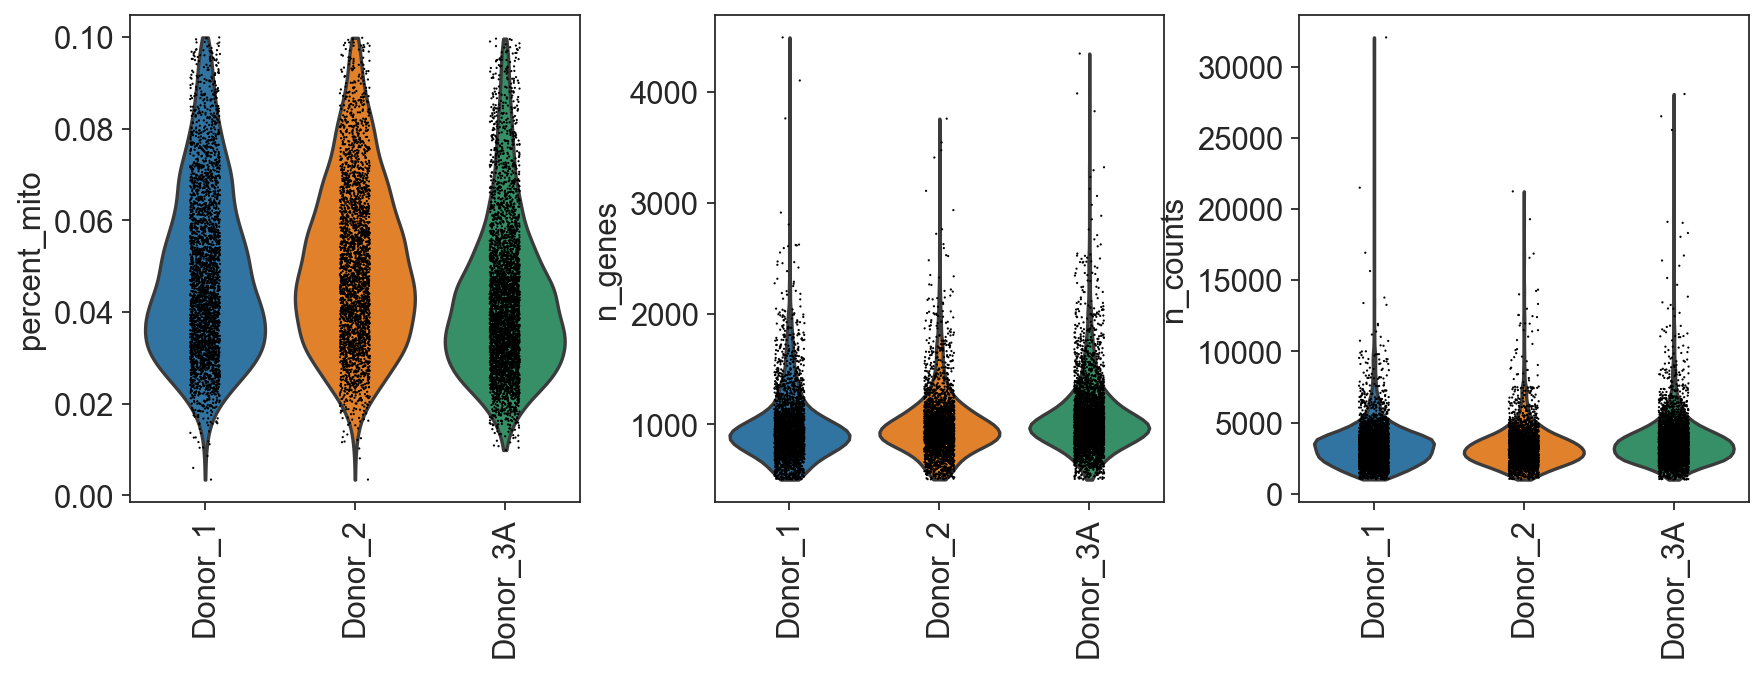

In [20]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

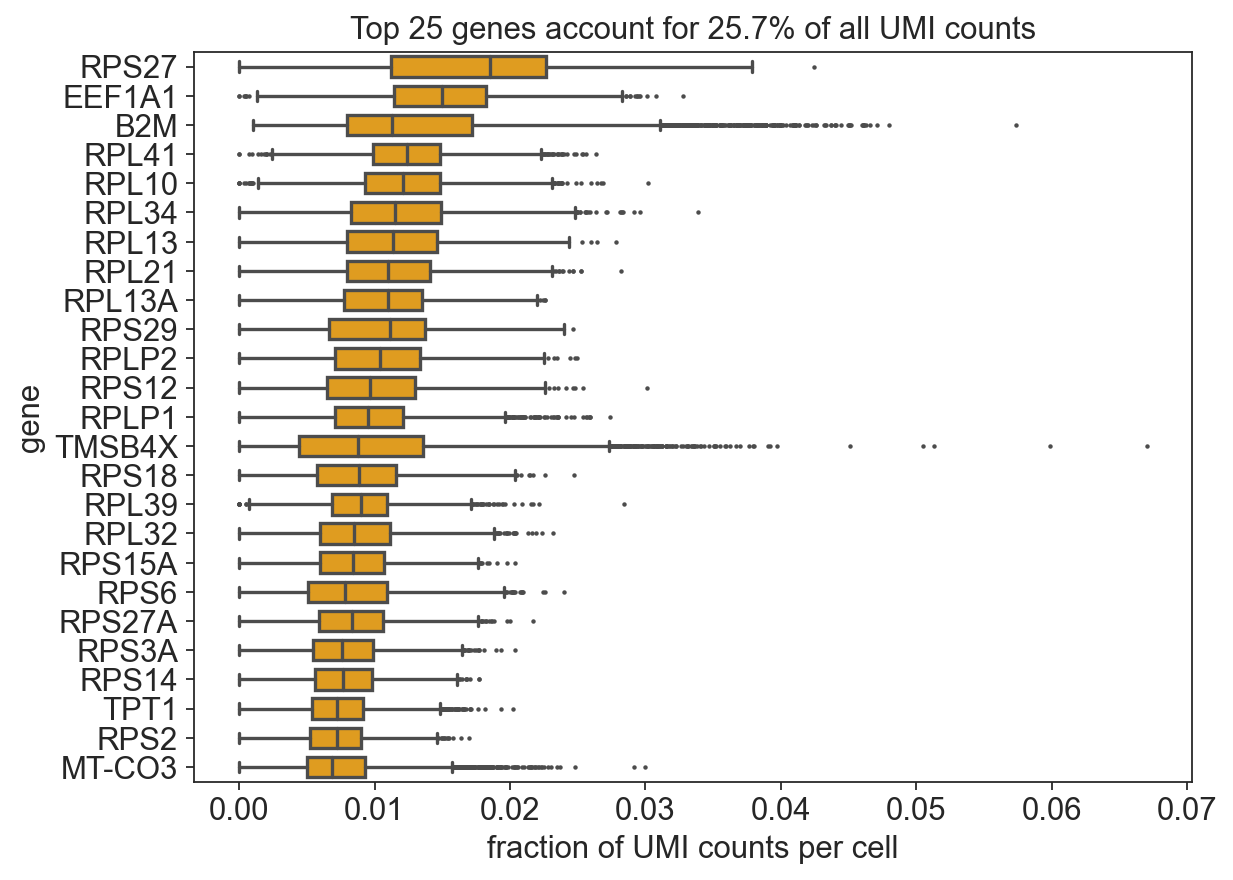

In [21]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

### Per-cell normalization and output of the normalized data

In [ ]:
adata = bc.st.per_cell_normalize(adata, results_folder)

adata normalized per cell


LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: 	Time for per-cell normalization: 0.707s


log1p values saved into adata.raw
writing out matrix.mtx ...


We perform an additional QC, which checks the dynamic range of ubiquitously expressed marker genes.

In [ ]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')

### Feature selection (highly variable genes) for clustering ###

In [ ]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [ ]:
adata 

In [ ]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

### PCA-based neighborhood analysis and UMAP with optional batch correction

We use the Batch Balanced K-Nearest Neighbourhood (bbknn, [Teichlab/bbknn](https://github.com/Teichlab/bbknn)) method as the batch correction method.

In [ ]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering

In [ ]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [ ]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

In [ ]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

### Additional Labeling ###

If `labeling_to_use` is specified, additional labels are taken from annotations in "metadata.tsv", and the data associated with additional labelling will be exported to files. And the fract_pos.gct and average.gct files are generated.

In [ ]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

### Complete the log-file

In [ ]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

### Write QC Report

In [ ]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

### Session info

Finally, we report the session info with the package [sinfo](https://gitlab.com/joelostblom/sinfo).

In [ ]:
sinfo()